# Graduate Admissions

This data set concerns test scores and other admissions variables for a Graduate program and the chance of admission for each student. The first portion of this notebook performs a principal component analysis of the data set in order to reduce its dimensionality. The data set is from [Kaggle](https://www.kaggle.com/mohansacharya/graduate-admissions).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read table
admissions = (pd
              .read_csv('admissions_predictions.csv', index_col='Serial No.')
              .rename({'Chance of Admit ' : 'Chance of Admit'}, axis=1))
admissions.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


## Principal Component Analysis
Principal component analysis (PCA) is a tool to help visualize higher-dimensional data in 2 dimensions (e.g. as a scatterplot). It is founded in the linear algebra technique of singular value decomposition. For a detailed explanation of PCA, see the PCA section of my [avocado notebook](../avocado/avocado#principal-component-analysis). To begin performing the PCA, we first make a scree plot to determine if the data can be well represented in 2 dimensions.

In [3]:
# extracting the df as a numpy matrix
admissions_matrix = admissions.values

# normalizing the data within each column
normed_admissions = (admissions_matrix - np.mean(admissions_matrix, axis=0))/ np.sqrt(admissions_matrix.shape[0])

# performing SVD on the matrix
u, sigma, vt = np.linalg.svd(normed_admissions, full_matrices=False)

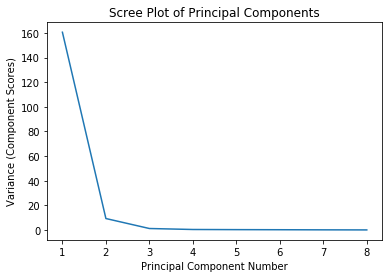

In [4]:
# plotting the scree plot
sns.lineplot(x = range(1, 9), y = sigma**2)
plt.title('Scree Plot of Principal Components')
plt.xlabel('Principal Component Number')
plt.ylabel('Variance (Component Scores)');

Based on how high PC1 and PC2 are relative to the other principal components, the data should be well-represented in 2D. We now use `seaborn` to plot a scatterplot of PC2 vs. PC1.

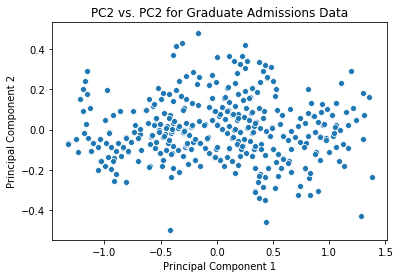

In [5]:
admissions_2d = normed_admissions @ vt.T[:, 0:2]

sns.scatterplot(x = admissions_2d[:,0], y = admissions_2d[:,1])
plt.title("PC2 vs. PC2 for Graduate Admissions Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2");

## Multivariate Linear Regression

The next thing to look at is building a linear regression predictor of the chance of admission using the data set. This predictor will take in the values in all of the columns (except `Chance of Admit`) and predict the chance of admission for that student. The model will be build using the `linear_model` sublibrary of `scikit-learn`, a machine learning library in Python.

In [7]:
# to refresh our memory
admissions.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


The values in most of the columns are self-explanatory, and the distances between the discrete values of the columns so small that they will be treated as continuous variables in the model. The only exceptions to this rule are the `University Rating` and `Research` columns. The `University Rating` column represents an ordinal variable with possible values 1, 2, 3, 4, and 5:

In [8]:
admissions['University Rating'].unique()

array([4, 3, 2, 5, 1])

The `Research` column represents whether or not a student has engaged in research and takes on the value `1` (yes) or `0` (no):

In [9]:
admissions['Research'].unique()

array([1, 0])

To account for these variables, our data processing will [one-hot encode](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) the `University Rating` variable. Because the `Research` variable only has possible values 0 and 1, it is already one-hot encoded for us. The function `process_data` below takes in a dataframe and performs the one-hot encoding on the `University Rating` variable. It returns a dataframe that does not contain the `Chance of Admit` column and a vector with the `Chance of Admit` values.

In [16]:
def process_data(original_data):
    """
    Processes data for use in linear regression model
    """
    
    data = original_data.copy()
    
    # one hot encode 'University Rating'
    data = pd.get_dummies(data,
                          columns = ['University Rating'],
                          drop_first = True)
    
    X = data.drop('Chance of Admit', axis=1)
    y = data['Chance of Admit']
    return X, y

In order to test the accuracy of our model, we first need to split our data into a training set and a testing set; we use the function `train_test_split` from `sklearn.model_selection` to accomplish this.

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(admissions)

In the cell below, we finally construct our linear regression model and predict the `Chance of Admit` values for the training and testing sets. This is done by applying the `process_data` function to each set, fitting the model to the training data, and running the predictor on the training and testing data.

In [20]:
import sklearn.linear_model as lm

# intialize the model
model = lm.LinearRegression()

# process the data
X_train, y_train = process_data(train)
X_test, y_test = process_data(test)

# fit the model
model.fit(X_train, y_train)

# predict for the training and testing sets
y_fitted = model.predict(X_train)
y_predicted = model.predict(X_test)

To assess the accuracy of our model, we will use the root-mean-squared error. If our predicted vector is $\mathbf{\hat{y}}$ and the original data is $\mathbf{y}$, this error function has the formula

$$ RMSE(\mathbf{\hat{y}}, \mathbf{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left ( \hat{y}_i - y_i \right ) ^2 } $$

The function `rmse` defined below takes in an array of predicted and original data and returns the RMSE from the above formula.

In [21]:
def rmse(predicted, actual):
    """
    Returns the RMSE of a model
    """
    return np.sqrt(np.mean((predicted - actual) ** 2))

train_rmse = rmse(y_fitted, y_train)
test_rmse = rmse(y_predicted, y_test)

print("Training RMSE: {}\nTest RMSE: {}".format(train_rmse, test_rmse))

### Improving the Model

Before constructing our model, we assumed that all of the variables in the data had a linear relationship with the `Chance of Admit` variable. This, however, is possibly erroneous, and to improve the accuracy of our model we should check that assumption. To that end, in the cell below, we plot scatterplots of `Chance of Admit` versus each variable in the data.

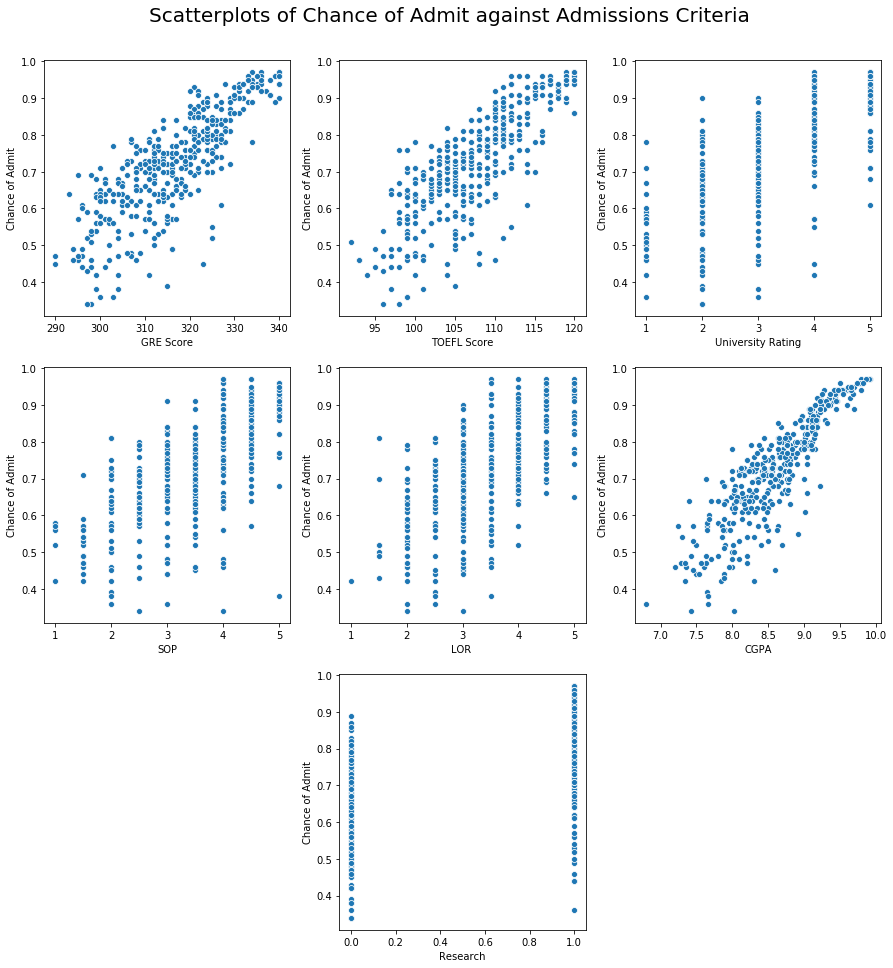

In [54]:
plt.figure(figsize=[15, 15])
plt.suptitle('Scatterplots of Chance of Admit against Admissions Criteria', size=20)
plt.subplots_adjust(top=.93)

i = 1
for col in admissions.drop('Chance of Admit', axis=1).columns:
    plt.subplot(3, 3, i)
    sns.scatterplot(admissions[col], admissions['Chance of Admit'])
    i += 1
    if i == 7:
        i += 1

From the plots above, it looks like the `Research` variable is not too well correlated with `Chance of Admit`, so in our fine-tuned model we will remove it from consideration. Also note that the `CGPA` curve looks almost like a square root function, so we will add column to the data with the square roots of this column; in this way, our model will still be linear in its coefficients but a root function in this feature.

The function `tuned_process` defined below processes the data by one-hot encoding the `University Rating` column (as before), adding in the square root of the `CGPA` column, and removing the `Research` column (using a helper function `drop_cols`). It returns the same items as `process_data` from earlier.

In [44]:
def drop_cols(df, cols):
    return df.drop(cols, axis=1)

def tuned_process(original_data):
    """
    Processes data for linear modeling
    """
    
    data = original_data.copy()
    
    # one hot encode 'University Rating'
    data = pd.get_dummies(data,
                          columns = ['University Rating'],
                          drop_first = True)
    
    # add in col with sqrt(cgpa)
    data['CGPA^0.5'] = data['CGPA'] ** 0.5
    
    # drop research
    data = drop_cols(data, 'Research')
    
    X = data.drop('Chance of Admit', axis=1)
    y = data['Chance of Admit']
    return X, y

In the cell below, we apply our fined-tuned model to the same dataset and look at the new RMSEs.

In [46]:
tuned_model = lm.LinearRegression()

X_train_tuned, y_train_tuned = tuned_process(train)
X_test_tuned, y_test_tuned = tuned_process(test)

tuned_model.fit(X_train_tuned, y_train_tuned)
y_fitted_tuned = tuned_model.predict(X_train_tuned)
y_predicted_tuned = tuned_model.predict(X_test_tuned)

# calculate RMSE of prediction
train_rmse_tuned = rmse(y_fitted_tuned, y_train_tuned)
test_rmse_tuned = rmse(y_predicted_tuned, y_test_tuned)

print("Training RMSE: {}\nTest RMSE: {}".format(train_rmse_tuned, test_rmse_tuned))

Training RMSE: 0.06153302769443445
Test RMSE: 0.06996680529504397


To see if our model improved much, we can check the reduction in RMSE by comparing the original RMSEs to the new RMSEs:

In [47]:
# calculate reduction in RMSE
print('Training RMSE Reduction: {}\nTest RMSE Reduction: {}'.format(
    train_rmse - train_rmse_tuned, test_rmse - test_rmse_tuned
))

Training RMSE Reduction: -0.0009908159905003822
Test RMSE Reduction: 0.0005201863228481846


The modifications we made made very little impact on the RMSE, whether positive or negative, so our new model is, roughly speaking, about as good as our original model.

### Bootstrapping the Model

To get an idea of the steady-state RMSE of this model, we can bootstrap our dataset and look at the average RMSE across many repetitions. To begin this process, we define a function `run_lm` which automates the entire process of calculating the RMSE from `train_test_split` to the `rmse` function. It returns a 2-tuple with the training and testing RMSE.

In [51]:
def run_lm(data, processor):
    
    # split into training and test sets
    train, test = train_test_split(admissions)
    
    # initialize linear regression model
    model = lm.LinearRegression()
    
    # process the data
    X_train, y_train = processor(train)
    X_test, y_test = processor(test)
    
    # fit the model to the training set
    model.fit(X_train, y_train)
    
    # predict the training and testing outcomes
    y_fitted = model.predict(X_train)
    y_predicted = model.predict(X_test)
    
    # calculate RMSE
    train_rmse = rmse(y_fitted, y_train)
    test_rmse = rmse(y_predicted, y_test)
    
    return train_rmse, test_rmse

In the cell below, we bootstrap our data set 100,000 times and collect the training and testing RMSEs into lists, which we then average to look at the steady-state RMSE. We also seed `np.random` to ensure that the values we obtain are reproducible.

In [53]:
# bootstrap the data set
reps = 100000
training_rmses, testing_rmses = [], []
np.random.seed(13) # seeding np.random for reproducibility

for _ in np.arange(1000):
    rmses = run_lm(admissions, tuned_process)
    training_rmses += [rmses[0]]
    testing_rmses += [rmses[1]]
    
print('Average Training RMSE: {}\nAverage Test RMSE: {}'.format(
    np.mean(training_rmses), np.mean(testing_rmses)
))

Average Training RMSE: 0.06315478365047726
Average Test RMSE: 0.06519462752608964


## Sources

Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019